In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, NamedTuple, Tuple

In [78]:
results = pd.read_csv('../results/processed_data.csv')
results.head()

,timestamp,user_id,day,quiz_id,image_index,illusion_filename,user_answer,response_time,speed_group,display_time,correct_answer,line_length1,line_length2,actual_difference,arrow_length,angle,arrow_color,is_control,is_correct
0,2024-11-04 21:33:40,mattrau1,1,2,0,muller_lyer_day1_illusion25.svg,Left,8.259,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
1,2024-11-04 21:33:41,jonah.harmon,1,0,0,muller_lyer_day1_illusion4.svg,Left,4.777,Group 1 - Fast,0.5,Same length,180,180,0,20,36,black,False,False
2,2024-11-04 21:33:44,mattrau1,1,2,1,muller_lyer_day1_illusion30.svg,Left,2.741,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,False
3,2024-11-04 21:33:45,jonah.harmon,1,0,1,muller_lyer_day1_illusion11.svg,Same length,2.907,Group 1 - Fast,0.5,Same length,205,205,0,20,36,red,False,True
4,2024-11-04 21:33:47,mwhite,1,2,0,muller_lyer_day1_illusion25.svg,Same length,3.467,Group 2 - Fast,0.5,Same length,200,200,0,20,36,red,True,True


In [79]:
class ParticipantStats(NamedTuple):
    user_id: str
    total_trials: int
    correct_black: int
    total_black: int
    correct_red: int
    total_red: int
    avg_rt_fast: float
    avg_rt_slow: float
    correct_fast: int
    total_fast: int
    correct_slow: int
    total_slow: int

In [80]:
def calculate_participant_stats(df: pd.DataFrame) -> Dict[str, ParticipantStats]:
    """Calculate statistics for each participant."""
    stats = {}
    
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id]
        
        # Calculate color-based stats
        black_trials = user_data[user_data['arrow_color'] == 'black']
        red_trials = user_data[user_data['arrow_color'] == 'red']
        
        # Calculate speed-based stats
        fast_trials = user_data[user_data['speed_group'].str.contains('Fast')]
        slow_trials = user_data[user_data['speed_group'].str.contains('Slow')]
        
        stats[user_id] = ParticipantStats(
            user_id=user_id,
            total_trials=len(user_data),
            correct_black=len(black_trials[black_trials['is_correct']]),
            total_black=len(black_trials),
            correct_red=len(red_trials[red_trials['is_correct']]),
            total_red=len(red_trials),
            avg_rt_fast=fast_trials['response_time'].mean(),
            avg_rt_slow=slow_trials['response_time'].mean(),
            correct_fast=len(fast_trials[fast_trials['is_correct']]),
            total_fast=len(fast_trials),
            correct_slow=len(slow_trials[slow_trials['is_correct']]),
            total_slow=len(slow_trials)
        )
    
    return stats

In [81]:
def create_comparison_visualization(stats: Dict[str, ParticipantStats]) -> None:
    """Create a visualization comparing fast vs slow performance."""
    # Prepare data for plotting
    plot_data = []
    
    for stat in stats.values():
        # Only include data points where trials exist
        if stat.total_fast > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Fast',
                'Accuracy (%)': (stat.correct_fast / stat.total_fast * 100)
            })
        if stat.total_slow > 0:
            plot_data.append({
                'user_id': stat.user_id,
                'Speed': 'Slow',
                'Accuracy (%)': (stat.correct_slow / stat.total_slow * 100)
            })
    
    plot_data = pd.DataFrame(plot_data)
    
    if len(plot_data) == 0:
        print("Warning: No data available for visualization")
        return
    
    # Create the visualization
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create box plot with individual points
    sns.boxplot(data=plot_data, x='Speed', y='Accuracy (%)', color='lightgray')
    sns.swarmplot(data=plot_data, x='Speed', y='Accuracy (%)', color='darkblue', size=8)
    
    # Customize the plot
    plt.title('Accuracy Comparison: Fast vs Slow Display Times', pad=20)
    plt.ylabel('Accuracy (%)')
    
    # Add mean lines for each condition
    means = plot_data.groupby('Speed')['Accuracy (%)'].mean()
    for i, speed in enumerate(means.index):
        plt.hlines(means[speed], i-0.3, i+0.3, color='red', linestyles='dashed', label='Mean' if i == 0 else '')
    
    plt.legend()
    plt.tight_layout()

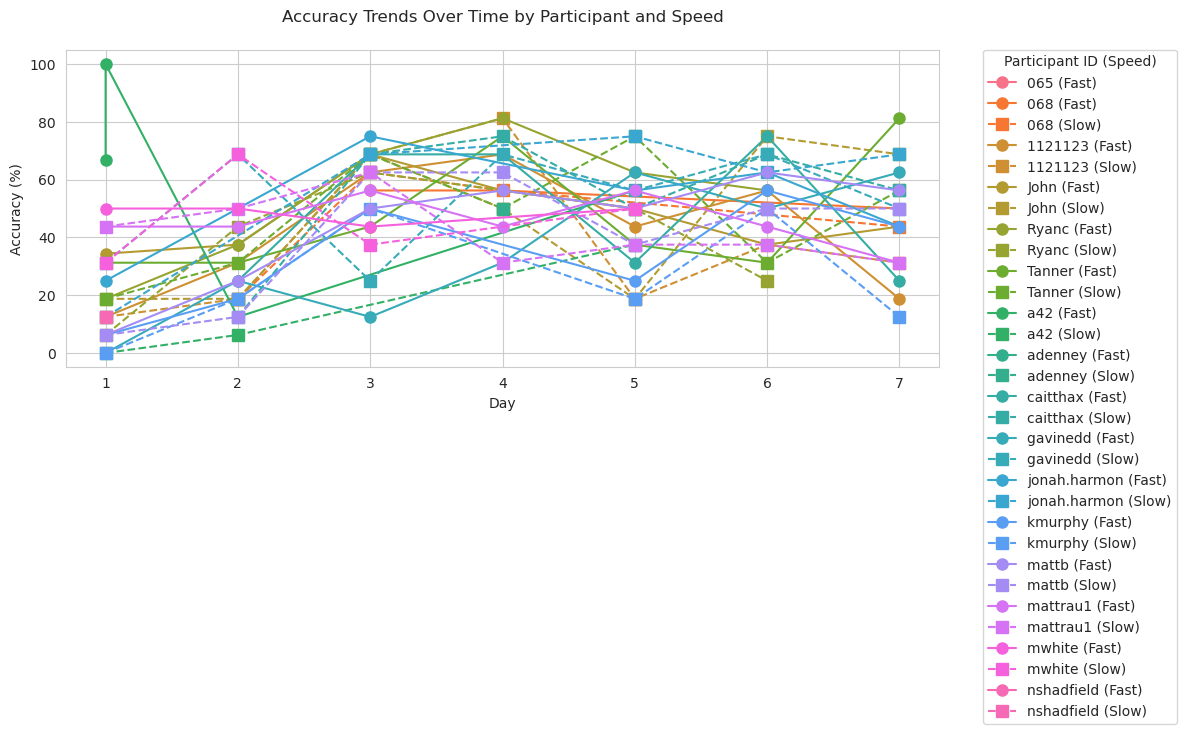

In [82]:
def create_accuracy_trend_visualization(df: pd.DataFrame, users_to_include: list = None) -> None:
    """
    Create a line plot showing accuracy trends over days for selected participants, separated by speed.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    users_to_include : list, optional
        List of user IDs to include in the visualization. If None, includes all users.
    """
    # Filter for specified users if provided
    if users_to_include is not None:
        df = df[df['user_id'].isin(users_to_include)]
        if df.empty:
            print("No data found for specified users.")
            return
    
    # Calculate daily accuracy for each participant and speed condition
    daily_accuracy = df.groupby(['user_id', 'day', 'speed_group']).agg({
        'is_correct': ['count', 'sum']
    }).reset_index()
    
    # Calculate accuracy percentage
    daily_accuracy.columns = ['user_id', 'day', 'speed_group', 'total_trials', 'correct_trials']
    daily_accuracy['accuracy'] = (daily_accuracy['correct_trials'] / 
                                daily_accuracy['total_trials'] * 100)
    
    # Simplify speed group names
    daily_accuracy['speed'] = daily_accuracy['speed_group'].apply(
        lambda x: 'Fast' if 'Fast' in x else 'Slow'
    )
    
    # Create the visualization
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    
    # Get unique users for color assignment
    users = sorted(df['user_id'].unique())
    colors = sns.color_palette("husl", n_colors=len(users))
    
    # Create line plot for each user and speed condition
    for i, user in enumerate(users):
        user_data = daily_accuracy[daily_accuracy['user_id'] == user]
        
        # Plot fast condition (solid line)
        fast_data = user_data[user_data['speed'] == 'Fast']
        if not fast_data.empty:
            plt.plot(fast_data['day'], fast_data['accuracy'], 
                    color=colors[i], linestyle='-', marker='o',
                    label=f'{user} (Fast)', markersize=8)
        
        # Plot slow condition (dashed line)
        slow_data = user_data[user_data['speed'] == 'Slow']
        if not slow_data.empty:
            plt.plot(slow_data['day'], slow_data['accuracy'], 
                    color=colors[i], linestyle='--', marker='s',
                    label=f'{user} (Slow)', markersize=8)
    
    # Customize the plot
    plt.title('Accuracy Trends Over Time by Participant and Speed', pad=20)
    plt.xlabel('Day')
    plt.ylabel('Accuracy (%)')
    
    # Adjust x-axis to show only integer days
    plt.xticks(sorted(daily_accuracy['day'].unique()))
    
    # Add legend with a title
    plt.legend(title='Participant ID (Speed)',
              bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              borderaxespad=0)
    
    # Ensure no labels are cut off
    plt.tight_layout()

# Example usage:
# For all users
create_accuracy_trend_visualization(results)

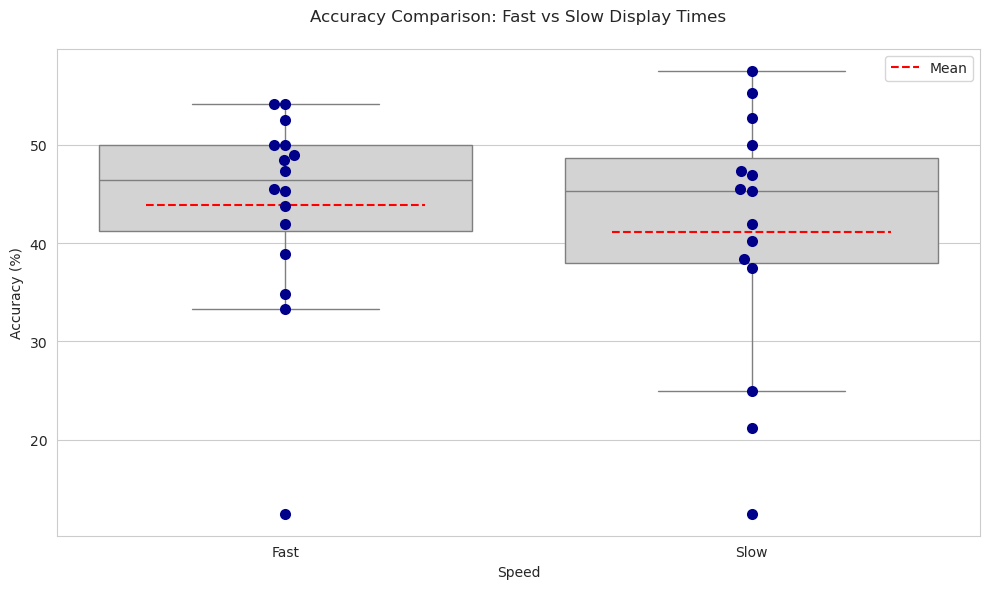

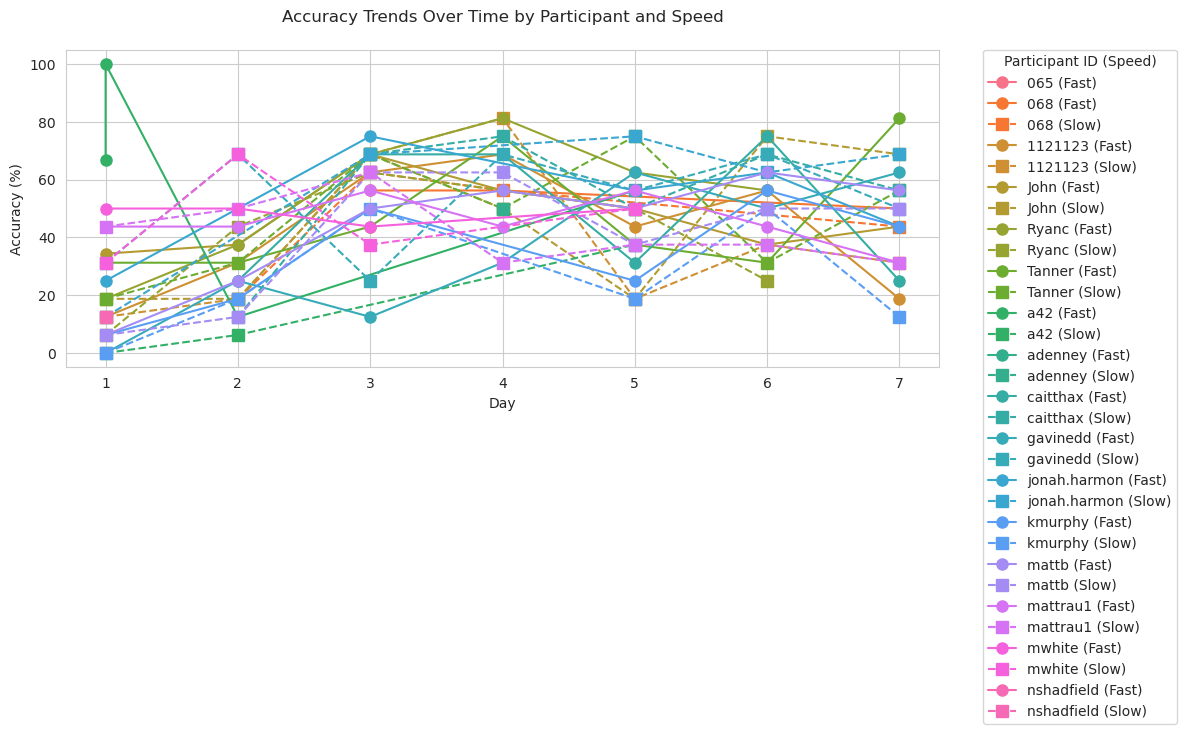

In [83]:
# Calculate statistics for all participants
participant_stats = calculate_participant_stats(results)

# Create visualizations
create_comparison_visualization(participant_stats)
plt.show()

create_accuracy_trend_visualization(results)
plt.show()

In [84]:
def remap_user_ids(df: pd.DataFrame, 
                   id_column: str,
                   mapping_dict: dict,
                   verbose: bool = True) -> pd.DataFrame:
    """
    Remap user IDs in a DataFrame based on a provided mapping dictionary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame containing user IDs to be remapped
    id_column : str
        The name of the column containing user IDs
    mapping_dict : dict
        Dictionary mapping incorrect user IDs to their correct versions
        e.g., {'old_id1': 'new_id1', 'old_id2': 'new_id2'}
    verbose : bool, default=True
        If True, prints summary of changes made
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with remapped user IDs
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Keep track of changes for reporting
    changes = {}
    
    # Apply the mapping
    for old_id, new_id in mapping_dict.items():
        mask = df_clean[id_column] == old_id
        count = mask.sum()
        if count > 0:
            df_clean.loc[mask, id_column] = new_id
            changes[old_id] = {'new_id': new_id, 'count': count}
    
    # Print summary if verbose is True
    if verbose and changes:
        print("\nUser ID Remapping Summary:")
        print("-" * 50)
        for old_id, info in changes.items():
            print(f"Renamed {info['count']} instances of '{old_id}' to '{info['new_id']}'")
        print(f"\nUnique user IDs after remapping: {df_clean[id_column].nunique()}")
    
    return df_clean


id_mapping = {
    '065': '068'
}

# Apply the remapping
results_clean = remap_user_ids(results, 
                             id_column='user_id', 
                             mapping_dict=id_mapping)

# Optional: Verify the changes
print("\nUnique user IDs in cleaned dataset:")
print(sorted(results_clean['user_id'].unique()))


User ID Remapping Summary:
--------------------------------------------------
Renamed 16 instances of '065' to '068'

Unique user IDs after remapping: 15

Unique user IDs in cleaned dataset:
['068', '1121123', 'John', 'Ryanc', 'Tanner', 'a42', 'adenney', 'caitthax', 'gavinedd', 'jonah.harmon', 'kmurphy', 'mattb', 'mattrau1', 'mwhite', 'nshadfield']


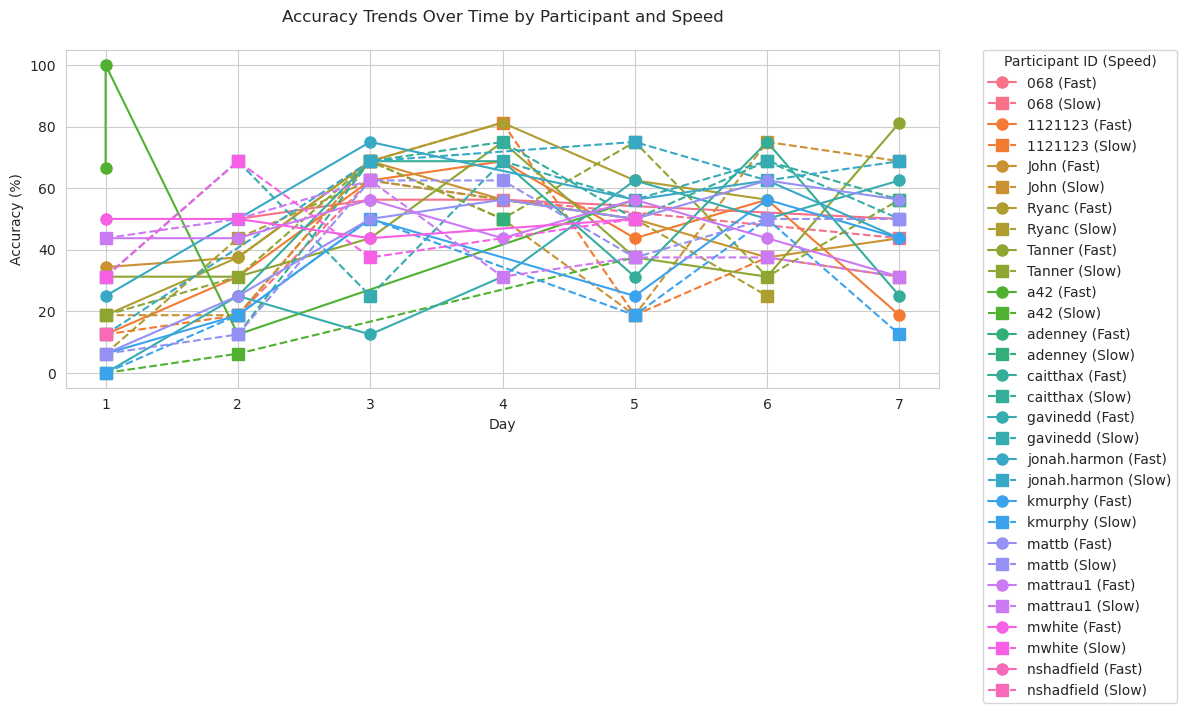

In [85]:
create_accuracy_trend_visualization(results_clean)
plt.show()

In [ ]:
# clean_data_sample = results_clean.sample(100)
# clean_data_sample.to_csv('../results/clean_data_sample.csv', index=False)

In [86]:
import pandas as pd
from typing import Dict, Tuple

def identify_duplicate_trials(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identify cases where users answered the same question multiple times in a quiz on the same day.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing duplicate trial entries
    """
    # Count occurrences of each question by each user in each quiz
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id', 'image_index']).size().reset_index(name='attempts')
    
    # Filter for cases with multiple attempts
    duplicates = trial_counts[trial_counts['attempts'] > 1]
    
    if len(duplicates) > 0:
        print(f"\nFound {len(duplicates)} instances of duplicate trial attempts:")
        for _, row in duplicates.iterrows():
            print(f"User {row['user_id']} attempted question {row['image_index']} "
                  f"in quiz {row['quiz_id']} on day {row['day']} {row['attempts']} times")
    
    return duplicates

def identify_incomplete_quizzes(df: pd.DataFrame, expected_trials: int) -> pd.DataFrame:
    """
    Identify quizzes where users didn't complete all trials.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing incomplete quiz information
    """
    # Count trials per quiz for each user
    trial_counts = df.groupby(['user_id', 'day', 'quiz_id']).agg(
        unique_trials=('image_index', 'nunique'),
        total_trials=('image_index', 'count')
    ).reset_index()
    
    # Identify incomplete quizzes or quizzes with duplicate trials
    incomplete = trial_counts[
        (trial_counts['unique_trials'] != expected_trials) | 
        (trial_counts['total_trials'] != expected_trials)
    ]
    
    if len(incomplete) > 0:
        print(f"\nFound {len(incomplete)} problematic quizzes:")
        for _, row in incomplete.iterrows():
            if row['unique_trials'] != row['total_trials']:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"{row['unique_trials']} unique trials, {row['total_trials']} total trials "
                      f"(indicates duplicate questions)")
            else:
                print(f"User {row['user_id']} quiz {row['quiz_id']} day {row['day']}: "
                      f"completed {row['unique_trials']}/{expected_trials} trials")
    
    return incomplete

def check_data_quality(df: pd.DataFrame, expected_trials: int = 48) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run all data quality checks and return results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
    
    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Duplicate trials DataFrame, Incomplete quizzes DataFrame
    """
    print(f"Running data quality checks (expected {expected_trials} trials per quiz)...")
    
    duplicates = identify_duplicate_trials(df)
    incomplete = identify_incomplete_quizzes(df, expected_trials)
    
    # Get detailed information about specific cases
    if len(duplicates) > 0:
        print("\nDetailed information for duplicate trials:")
        for _, dup in duplicates.iterrows():
            relevant_trials = df[
                (df['user_id'] == dup['user_id']) & 
                (df['day'] == dup['day']) & 
                (df['quiz_id'] == dup['quiz_id']) &
                (df['image_index'] == dup['image_index'])
            ]
            print(f"\nDetailed trials for duplicate question {dup['image_index']} "
                  f"by {dup['user_id']} on day {dup['day']} quiz {dup['quiz_id']}:")
            print(relevant_trials[['timestamp', 'image_index', 'user_answer', 'is_correct']].sort_values('timestamp'))
    
    return duplicates, incomplete

# Example usage
# Check with default 48 trials
# duplicates, incomplete = check_data_quality(results)

# Or specify a different number of expected trials
duplicates, incomplete = check_data_quality(results_clean, expected_trials=49)

Running data quality checks (expected 49 trials per quiz)...

Found 33 instances of duplicate trial attempts:
User John attempted question 0 in quiz 0 on day 1 2 times
User John attempted question 1 in quiz 0 on day 1 2 times
User John attempted question 2 in quiz 0 on day 1 2 times
User John attempted question 3 in quiz 0 on day 1 2 times
User John attempted question 4 in quiz 0 on day 1 2 times
User John attempted question 5 in quiz 0 on day 1 2 times
User John attempted question 6 in quiz 0 on day 1 2 times
User John attempted question 7 in quiz 0 on day 1 2 times
User John attempted question 8 in quiz 0 on day 1 2 times
User John attempted question 9 in quiz 0 on day 1 2 times
User John attempted question 10 in quiz 0 on day 1 2 times
User John attempted question 11 in quiz 0 on day 1 2 times
User John attempted question 12 in quiz 0 on day 1 2 times
User John attempted question 13 in quiz 0 on day 1 2 times
User John attempted question 14 in quiz 0 on day 1 2 times
User John attem

In [87]:
def remove_duplicate_trials(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Remove duplicate trials from the dataset, keeping only the first instance.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints summary of removed duplicates
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame with duplicates removed
    """
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Sort by timestamp to ensure we keep the first instance
    df_clean = df_clean.sort_values('timestamp')
    
    # Count initial trials
    initial_count = len(df_clean)
    
    # Drop duplicates based on user_id, day, quiz_id, and image_index
    df_clean = df_clean.drop_duplicates(
        subset=['user_id', 'day', 'quiz_id', 'image_index'],
        keep='first'
    )
    
    # Count removed trials
    removed_count = initial_count - len(df_clean)
    
    if verbose and removed_count > 0:
        print(f"\nRemoved {removed_count} duplicate trials:")
        print(f"Initial trial count: {initial_count}")
        print(f"Final trial count: {len(df_clean)}")
        
        # Get counts by user
        user_counts = df.groupby('user_id').size() - df_clean.groupby('user_id').size()
        users_with_duplicates = user_counts[user_counts > 0]
        
        print("\nDuplicates removed by user:")
        for user, count in users_with_duplicates.items():
            print(f"{user}: {count} duplicate trials removed")
    
    return df_clean

def clean_and_validate_data(df: pd.DataFrame, expected_trials: int = 48) -> pd.DataFrame:
    """
    Clean data by removing duplicates and validate the results.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    expected_trials : int, default=48
        Expected number of trials per quiz
        
    Returns:
    --------
    pandas.DataFrame
        Cleaned DataFrame
    """
    print("Starting data cleaning process...")
    
    # Remove duplicates
    df_clean = remove_duplicate_trials(df)
    
    # Validate results
    print("\nValidating cleaned data...")
    duplicates, incomplete = check_data_quality(df_clean, expected_trials)
    
    if len(duplicates) == 0:
        print("\nAll duplicates successfully removed!")
    else:
        print("\nWarning: Some duplicates remain after cleaning!")
    
    # Check if any quizzes are now incomplete due to duplicate removal
    if len(incomplete) > 0:
        print("\nNote: Some quizzes are incomplete after duplicate removal.")
        print("You may want to handle these cases separately.")
    
    return df_clean

# Example usage
# Clean the data
results_drop_dups = clean_and_validate_data(results_clean, expected_trials=50)

# Optional: Compare trial counts before and after cleaning
print("\nTrial counts by user (before cleaning):")
print(results.groupby('user_id').size())
print("\nTrial counts by user (after cleaning):")
print(results_drop_dups.groupby('user_id').size())

Starting data cleaning process...

Removed 34 duplicate trials:
Initial trial count: 2485
Final trial count: 2451

Duplicates removed by user:
John: 16 duplicate trials removed
a42: 2 duplicate trials removed
nshadfield: 16 duplicate trials removed

Validating cleaned data...
Running data quality checks (expected 50 trials per quiz)...

Found 156 problematic quizzes:
User 068 quiz 4 day 2: completed 16/50 trials
User 068 quiz 7 day 2: completed 16/50 trials
User 068 quiz 8 day 3: completed 16/50 trials
User 068 quiz 9 day 3: completed 16/50 trials
User 068 quiz 12 day 4: completed 16/50 trials
User 068 quiz 13 day 4: completed 16/50 trials
User 068 quiz 24 day 7: completed 16/50 trials
User 068 quiz 25 day 7: completed 16/50 trials
User 1121123 quiz 0 day 1: completed 16/50 trials
User 1121123 quiz 1 day 1: completed 16/50 trials
User 1121123 quiz 4 day 2: completed 16/50 trials
User 1121123 quiz 5 day 2: completed 16/50 trials
User 1121123 quiz 8 day 3: completed 16/50 trials
User 112

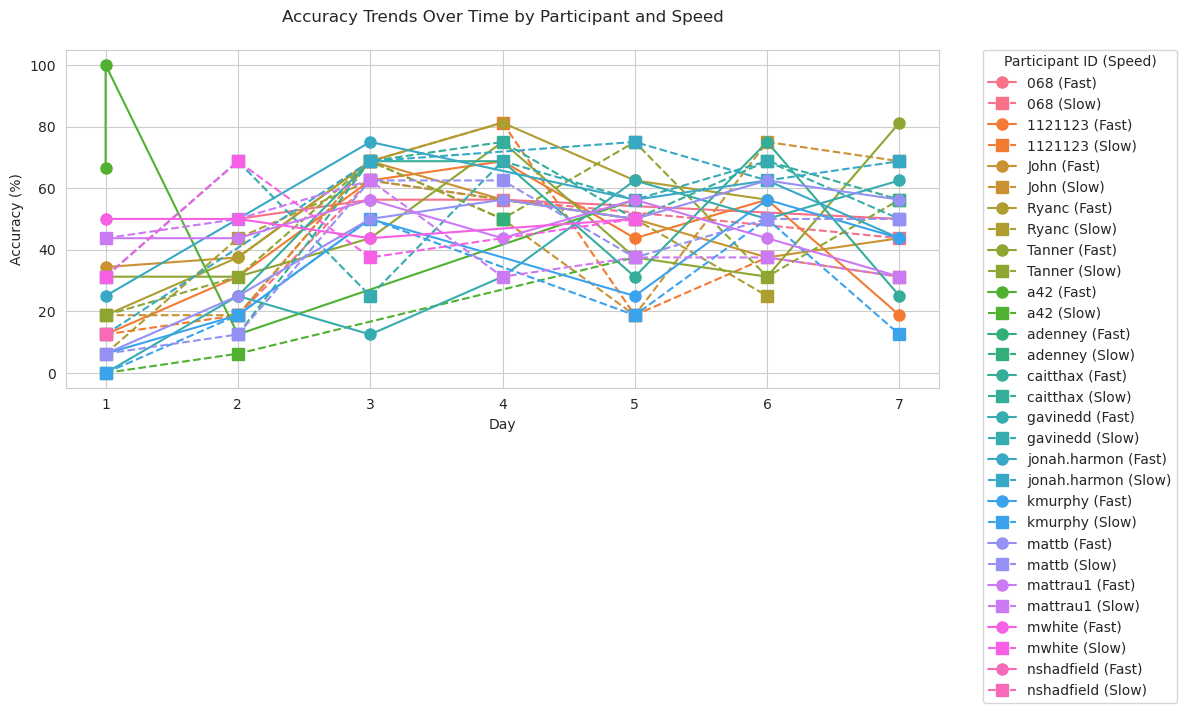

In [88]:
create_accuracy_trend_visualization(results_clean)
plt.show()

In [ ]:
# create_accuracy_trend_visualization(results_drop_dups, users_to_include=['HRB'])

In [89]:
def fix_quiz_day_assignments(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Fix cases where the same quiz appears on multiple days by properly separating and 
    reassigning quiz numbers to maintain sequential ordering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    verbose : bool, default=True
        If True, prints details about corrections made
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with corrected quiz assignments
    """
    df_fixed = df.copy()
    
    # Process each user separately
    for user in df_fixed['user_id'].unique():
        user_data = df_fixed[df_fixed['user_id'] == user]
        
        # Check for days with more than 2 quizzes or more than 96 trials
        problematic_days = user_data.groupby('day').agg({
            'quiz_id': ['nunique', 'count']
        }).reset_index()
        problematic_days.columns = ['day', 'num_quizzes', 'num_trials']
        problematic_days = problematic_days[
            (problematic_days['num_quizzes'] > 2) | 
            (problematic_days['num_trials'] > 96)
        ]
        
        if len(problematic_days) > 0 and verbose:
            print(f"\nProcessing user {user}")
            print(f"Found {len(problematic_days)} days with incorrect quiz assignments")
        
        # Process each problematic day
        for _, row in problematic_days.iterrows():
            day = row['day']
            day_data = user_data[user_data['day'] == day]
            
            # Get unique quizzes for this day
            quizzes = sorted(day_data['quiz_id'].unique())
            
            if verbose:
                print(f"\nDay {day}: Found {len(quizzes)} quizzes: {quizzes}")
            
            # Process each quiz after the first two
            for i, quiz_id in enumerate(quizzes[2:], start=2):
                # Get trials for this quiz
                quiz_trials = day_data[day_data['quiz_id'] == quiz_id]
                
                # Calculate new day (original day + 1)
                new_day = day + 1
                
                # Calculate new quiz ID (should be max + 1)
                new_quiz_id = df_fixed['quiz_id'].max() + 1
                
                if verbose:
                    print(f"Moving quiz {quiz_id} to day {new_day} with new quiz_id {new_quiz_id}")
                
                # Update the trials
                mask = (df_fixed['user_id'] == user) & \
                       (df_fixed['day'] == day) & \
                       (df_fixed['quiz_id'] == quiz_id)
                
                df_fixed.loc[mask, 'day'] = new_day
                df_fixed.loc[mask, 'quiz_id'] = new_quiz_id
    
    # Sort the DataFrame to make it easier to verify
    df_fixed = df_fixed.sort_values(['user_id', 'day', 'quiz_id'])
    
    return df_fixed

# Example usage
# Fix quiz assignments
results_fixed = fix_quiz_day_assignments(results_drop_dups)

# Verify the changes
def verify_quiz_assignments(df: pd.DataFrame):
    """Print summary of quiz assignments per user per day."""
    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        quiz_summary = user_data.groupby(['day'])[['quiz_id', 'speed_group']].agg({
            'quiz_id': ['count', 'unique'],
            'speed_group': 'unique'
        }).reset_index()
        quiz_summary.columns = ['day', 'total_trials', 'unique_quizzes', 'speeds']
        print(f"\nUser: {user}")
        print(quiz_summary)

# Run verification
print("\nVerifying quiz assignments after corrections:")
verify_quiz_assignments(results_fixed)


Processing user a42
Found 1 days with incorrect quiz assignments

Day 1: Found 3 quizzes: [0, 1, 2]
Moving quiz 2 to day 2 with new quiz_id 28

Verifying quiz assignments after corrections:

User: 068
   day  total_trials unique_quizzes                            speeds
0    2            32         [4, 7]  [Group 1 - Fast, Group 2 - Slow]
1    3            32         [8, 9]  [Group 1 - Fast, Group 1 - Slow]
2    4            32       [12, 13]  [Group 1 - Fast, Group 1 - Slow]
3    7            32       [24, 25]  [Group 1 - Fast, Group 1 - Slow]

User: 1121123
   day  total_trials unique_quizzes                            speeds
0    1            32         [0, 1]  [Group 1 - Fast, Group 1 - Slow]
1    2            32         [4, 5]  [Group 1 - Fast, Group 1 - Slow]
2    3            32         [8, 9]  [Group 1 - Fast, Group 1 - Slow]
3    4            32       [12, 13]  [Group 1 - Fast, Group 1 - Slow]
4    5            32       [16, 17]  [Group 1 - Fast, Group 1 - Slow]
5    6       

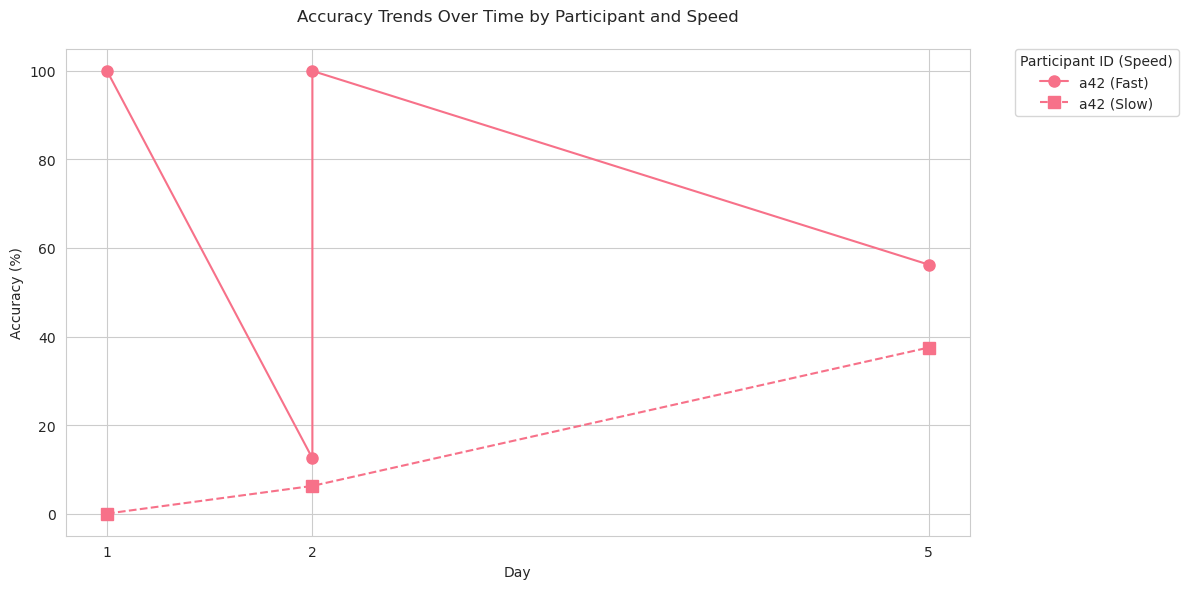

In [ ]:
create_accuracy_trend_visualization(results_fixed, users_to_include=['a42'])

In [93]:
def remove_users(df: pd.DataFrame, users_to_remove: list, verbose: bool = True) -> pd.DataFrame:
    """
    Remove specified users from the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the experiment data
    users_to_remove : list
        List of user IDs to remove from the dataset
    verbose : bool, default=True
        If True, prints summary of removed data
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with specified users removed
    """
    # Create a copy to avoid modifying the original DataFrame
    df_filtered = df.copy()
    
    # Store initial counts
    initial_users = df_filtered['user_id'].nunique()
    initial_trials = len(df_filtered)
    
    # Remove specified users
    df_filtered = df_filtered[~df_filtered['user_id'].isin(users_to_remove)]
    
    if verbose:
        # Calculate removed counts
        removed_users = initial_users - df_filtered['user_id'].nunique()
        removed_trials = initial_trials - len(df_filtered)
        
        print(f"\nRemoved {removed_users} users and {removed_trials} trials:")
        for user in users_to_remove:
            user_trials = len(df[df['user_id'] == user])
            print(f"- {user}: {user_trials} trials")
            
        print(f"\nRemaining users: {sorted(df_filtered['user_id'].unique())}")
        print(f"Remaining trials: {len(df_filtered)}")
    
    return df_filtered

# Example usage
users_to_remove = ['a42', 'adenney']
results_filtered = remove_users(results, users_to_remove)

# Verify the filtering
def verify_filtered_data(df: pd.DataFrame):
    """Print summary of remaining data."""
    print("\nData summary after filtering:")
    print(f"Total users: {df['user_id'].nunique()}")
    print(f"Total trials: {len(df)}")
    print("\nTrials per user:")
    print(df.groupby('user_id').size())

# Run verification
verify_filtered_data(results_filtered)


Removed 2 users and 101 trials:
- a42: 69 trials
- adenney: 32 trials

Remaining users: ['065', '068', '1121123', 'John', 'Ryanc', 'Tanner', 'caitthax', 'gavinedd', 'jonah.harmon', 'kmurphy', 'mattb', 'mattrau1', 'mwhite', 'nshadfield']
Remaining trials: 2384

Data summary after filtering:
Total users: 14
Total trials: 2384

Trials per user:
user_id
065              16
068             112
1121123         224
John            240
Ryanc           176
Tanner          224
caitthax        192
gavinedd        224
jonah.harmon    160
kmurphy         192
mattb           224
mattrau1        224
mwhite          128
nshadfield       48
dtype: int64


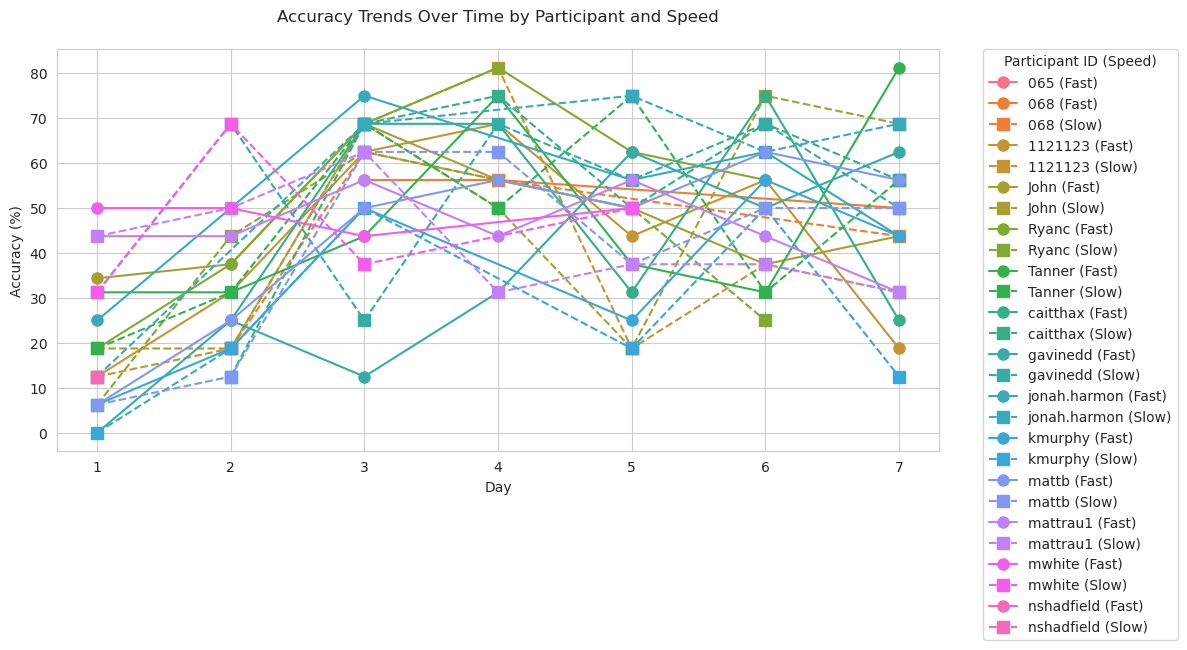

In [95]:
create_accuracy_trend_visualization(results_filtered)

In [96]:
results_filtered.to_csv('../results/cleaned_data.csv', index=False)